In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


### Data Loading and Pretrained models

In [2]:
def image_fetch(src,image_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".jpg" in l[i] or ".jpeg" in l[i] or ".png" in l[i]):
                image_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    image_fetch(str(src+l[i]+"/"),image_paths)
                except:
                    continue
                            
def class_fetch(image_paths)->(list,dict):
    s=set()
    for i in image_paths:
        s.add(i.split("/")[-2])
    d={}
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d

In [3]:
class modified_dataset_loader(Dataset):
    
    def __init__(self,targ_dir=None,paths=None,transformations=None):

        if(targ_dir!=None):
            self.transform=transformations
            self.paths=[]
            image_fetch(targ_dir,self.paths)
            self.classes, self.class_to_idx=class_fetch(self.paths)
        else:
            self.transform=transformations
            self.paths=paths
            self.classes, self.class_to_idx=class_fetch(self.paths)
            


    def load_image(self,index)-> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        image=self.load_image(index)
        class_val=self.class_to_idx[(self.paths[index]).split("/")[-2]]
        if(self.transform):
            image=self.transform(image)
        return image,class_val

In [4]:
batch_size=32
cpu_count=multiprocessing.cpu_count()
model_name="mobilenetv3_small_100.lamb_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

#transform_data=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
#                                              torchvision.transforms.Resize(size=(384,384))])

data_path=[]
image_fetch("../sample_small_dataset/Train/",data_path)

train,test=train_test_split(data_path,test_size=0.5)
test,val=train_test_split(test,test_size=0.5)

train_data=modified_dataset_loader(paths=train,transformations=transforms)
test_data=modified_dataset_loader(paths=test,transformations=transforms)
val_data=modified_dataset_loader(paths=val,transformations=transforms)

print(f"No. of images in Training set: {len(train)}\nNo. of images in Validation set: {len(val)}\nNo. of images in Test set: {len(test)}")

No. of images in Training set: 266
No. of images in Validation set: 134
No. of images in Test set: 133


In [5]:
train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
val_loader=torch.utils.data.DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

### Freezing layers and slight modification to model

In [6]:
count=0
for param in model.parameters(): #142 layers
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

'''
### Needs to be configured for LSTM
class modified_model(torch.nn.Module):
    def __init__(self,model,out_features,modify_bool=True,add_block_dropout_bool=True):
        super(modified_model,self).__init__()
        self.model=model
        self.model_in_features=model.head.in_features
        self.model.head=nn.Linear(in_features=self.model_in_features,out_features=out_features)
        self.modify_bool=modify_bool
        self.add_block_dropout_bool=add_block_dropout_bool

        
        def add_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=(torch.randint(low=0,high=50,size=(1,))/100).item())
        def default_block_dropouts():
            for i in range(len(self.model.blocks)):
                self.model.blocks[i].mlp.drop2=nn.Dropout(p=0)

        def modify():
            self.model.head=nn.Linear(in_features=self.model_in_features,out_features=1000)
            
            self.layer1=nn.Linear(in_features=12,out_features=128)
            self.layer2=nn.Linear(in_features=128,out_features=256)
            self.layer3=nn.Linear(in_features=256,out_features=512)
            self.relu=nn.ReLU();
            
            self.layer_final1=nn.Linear(in_features=(self.model.head.out_features+(self.layer3.out_features)),out_features=1024)
            self.layer_final2=nn.Linear(in_features=1024,out_features=out_features)
        if(self.add_block_dropout_bool):
            add_block_dropouts()
        else:
            default_block_dropouts()
        if(self.modify_bool):
            modify()

    
    def forward(self,x,y=None):
            if(self.modify_bool and y!=None):
                self.result_month=self.layer3(self.relu(self.layer2(self.relu(self.layer1(y)))))
                self.result_model=self.model(x)
                combination=torch.hstack((self.result_month,self.result_model.squeeze()))
                return self.layer_final2(self.relu(self.layer_final1(combination)))
            else:
                return self.model(x)


class simple_cnn(nn.Module):
    def __init__(self,total_classes=2):
        super().__init__()
        #[(W−K+2P)/S]+1
        
        # 384 x 384 x 3
        self.input_layer=nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1,padding=1,padding_mode="replicate",bias=True)
        # 384 x 384 x 128
        self.relu1=nn.ReLU()
        self.layer1=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=(3,3),stride=1)
        # 190 x 190 x 256
        
        self.relu2=nn.ReLU()
        self.layer2=nn.Conv2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 92 x 92 x 512

        self.relu3=nn.ReLU()
        self.layer3=nn.Conv2d(in_channels=128,out_channels=10,kernel_size=(3,3),stride=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # 44 x 44 x 1024

        
        self.flatten_layer=nn.Flatten()
        self.classification_head=nn.Sequential(nn.Linear(in_features=91*91*10,out_features=512),
                                              nn.ReLU(),
                                              nn.Linear(in_features=512,out_features=128),
                                              nn.ReLU(),
                                              nn.Linear(in_features=128,out_features=total_classes))
    def forward(self,x):
        self.convolution_output=self.flatten_layer(self.maxpool3(self.layer3(self.relu3(self.maxpool2(self.layer2(self.relu2(self.maxpool1(self.layer1(self.relu1(self.input_layer(x)))))))))))
        self.net_output=self.classification_head(self.convolution_output)
        return self.net_output'''

'\n### Needs to be configured for LSTM\nclass modified_model(torch.nn.Module):\n    def __init__(self,model,out_features,modify_bool=True,add_block_dropout_bool=True):\n        super(modified_model,self).__init__()\n        self.model=model\n        self.model_in_features=model.head.in_features\n        self.model.head=nn.Linear(in_features=self.model_in_features,out_features=out_features)\n        self.modify_bool=modify_bool\n        self.add_block_dropout_bool=add_block_dropout_bool\n\n        \n        def add_block_dropouts():\n            for i in range(len(self.model.blocks)):\n                self.model.blocks[i].mlp.drop2=nn.Dropout(p=(torch.randint(low=0,high=50,size=(1,))/100).item())\n        def default_block_dropouts():\n            for i in range(len(self.model.blocks)):\n                self.model.blocks[i].mlp.drop2=nn.Dropout(p=0)\n\n        def modify():\n            self.model.head=nn.Linear(in_features=self.model_in_features,out_features=1000)\n            \n      

In [7]:
#model=modified_model(model,len(train_data.classes),modify_bool=False,add_block_dropout_bool=True).to(device)
#model=simple_cnn(len(train_data.classes)).to(device)
model.classifier=nn.Linear(in_features=1024,out_features=len(train_data.classes),bias=True)
model=model.to(device)

### Slight Visualizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


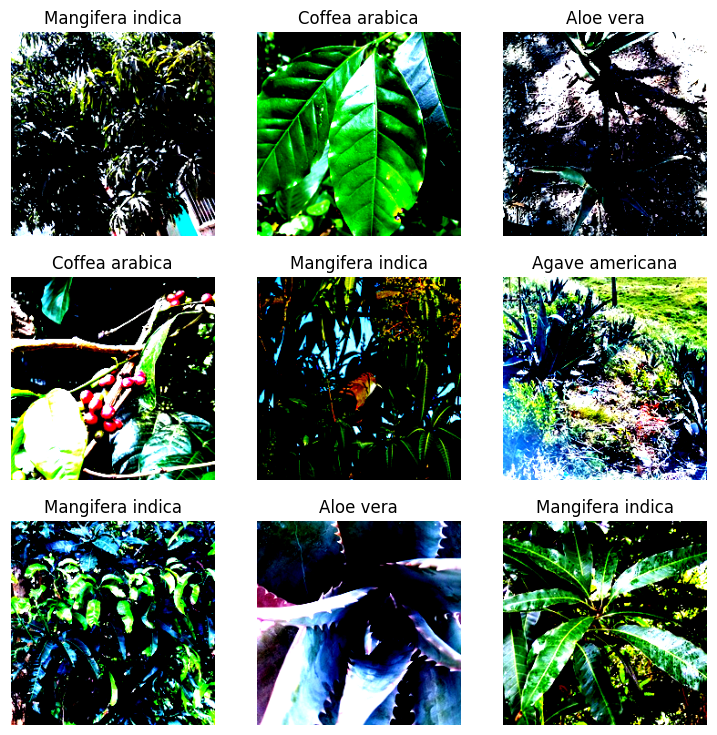

In [8]:
plt.figure(figsize=(9,9))
plt.axis(False)
for i in range(1,10):
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    data=next(iter(train_loader))
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(train_data.classes[label.item()])
    plt.axis(False)
    plt.imshow(image)
    

### Misc.

In [9]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

log_dir = "./"+model_name+"_tensorboard"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing the model (image)

In [10]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[ 0.0361, -0.4716,  0.1408,  0.7492],
        [-0.0609, -0.5341,  0.2940,  0.7011],
        [ 0.2729, -0.6700, -0.0434,  0.5368],
        [-0.0024, -0.4485, -0.1669,  0.9369],
        [-0.4442, -0.3265, -0.1877,  0.8145],
        [-0.0865, -0.1297,  0.5153,  0.6232],
        [-0.2611,  0.2822,  0.0640,  0.7477],
        [-0.6538, -0.5885,  0.0168,  0.4150],
        [-0.0997, -0.8658,  0.1790,  0.8472],
        [-0.6317, -0.5164, -0.0094,  0.2958],
        [-0.1987, -0.4387, -0.3554, -0.1988],
        [-0.3709, -0.5175, -0.1737,  0.6395],
        [ 0.2000, -0.0634,  0.0693,  0.6102],
        [-0.8119, -0.3917,  0.0681,  0.9010],
        [-0.0366, -0.5467, -0.3144,  0.5041],
        [ 0.0237, -0.0062, -0.2346,  0.3411],
        [-0.0464,  0.3901,  0.2358,  0.3746],
        [-0.5368, -0.7183, -0.2122,  0.2113],
        [-0.0046, -0.7369,  0.0686, -0.3889],
        [-0.2895,  0.6350,  0.4159, -0.0084],
        [-0.2987, -0.0500,  0.1427,  0.3562],
        [ 0.3388, -0.8924, -0.0570

### Training Loop for image classification

In [11]:
epochs=50

train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and val data
    temp_train_accuracy=[]
    temp_val_accuracy=[]
    temp_train_loss=[]
    temp_val_loss=[]

    net_train_accuracy=0
    net_val_accuracy=0
    net_train_loss=0
    net_val_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing on validation data:")
    model.eval()

    with tqdm(total=len(val_loader)) as pbar2:
        for x,y in val_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_val_accuracy.append(accuracy_test)
                temp_val_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
    net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
    val_accuracy.append(net_val_accuracy)
    val_loss.append(net_val_loss)
    writer.add_scalar("Val Accuracy",net_val_accuracy,i)
    writer.add_scalar("Val Loss",net_val_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Val Accuracy: {net_val_accuracy}  Val Loss: {net_val_loss}")
    print("\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.5881944444444445  Train Loss: 0.9300943348142836  Val Accuracy: 0.7604166666666667  Val Loss: 0.6697142422199249


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9048611111111112  Train Loss: 0.29562536709838444  Val Accuracy: 0.7854166666666667  Val Loss: 0.7705908805131912


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.9791666666666666  Train Loss: 0.06899230720268355  Val Accuracy: 0.7875  Val Loss: 0.937310416996479


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9673611111111112  Train Loss: 0.09733038468079434  Val Accuracy: 0.86875  Val Loss: 0.8104220279958099


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9541666666666667  Train Loss: 0.11432968928582138  Val Accuracy: 0.7791666666666667  Val Loss: 1.2840462744235992


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 0.9534722222222223  Train Loss: 0.19521110678195125  Val Accuracy: 0.775  Val Loss: 1.9802887630881743


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 0.9395833333333334  Train Loss: 0.19345259769923157  Val Accuracy: 0.75625  Val Loss: 1.660656177252531


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8:
Train Accuracy: 0.9611111111111111  Train Loss: 0.10658423064483537  Val Accuracy: 0.61875  Val Loss: 3.4397591590881347


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9:
Train Accuracy: 0.9430555555555556  Train Loss: 0.12227027759783798  Val Accuracy: 0.6333333333333333  Val Loss: 2.653475797176361


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10:
Train Accuracy: 0.9118055555555556  Train Loss: 0.2568326994983686  Val Accuracy: 0.7416666666666667  Val Loss: 1.9748005032539369


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11:
Train Accuracy: 0.8875  Train Loss: 0.2738905940204859  Val Accuracy: 0.7479166666666667  Val Loss: 1.1921618402004241


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12:
Train Accuracy: 0.9756944444444444  Train Loss: 0.09846114118893941  Val Accuracy: 0.7854166666666667  Val Loss: 0.9401215314865112


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13:
Train Accuracy: 0.9930555555555556  Train Loss: 0.03798133028774626  Val Accuracy: 0.85  Val Loss: 0.8097514725581277


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14:
Train Accuracy: 0.9965277777777778  Train Loss: 0.01164438646648907  Val Accuracy: 0.84375  Val Loss: 0.7837369214743376


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15:
Train Accuracy: 0.9784722222222223  Train Loss: 0.07054039240918225  Val Accuracy: 0.8104166666666666  Val Loss: 1.0795088052749633


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16:
Train Accuracy: 0.9708333333333334  Train Loss: 0.08441374109437068  Val Accuracy: 0.8  Val Loss: 1.236549660563469


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17:
Train Accuracy: 0.96875  Train Loss: 0.12790455353549784  Val Accuracy: 0.7729166666666667  Val Loss: 1.127626472711563


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18:
Train Accuracy: 0.9861111111111112  Train Loss: 0.057443680759105414  Val Accuracy: 0.7333333333333333  Val Loss: 1.3012211918830872


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19:
Train Accuracy: 0.9791666666666666  Train Loss: 0.049492708769523434  Val Accuracy: 0.7395833333333333  Val Loss: 1.4039133310317993


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20:
Train Accuracy: 0.9965277777777778  Train Loss: 0.014529389458604984  Val Accuracy: 0.7604166666666667  Val Loss: 1.838129186630249


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21:
Train Accuracy: 0.9965277777777778  Train Loss: 0.011776684317737818  Val Accuracy: 0.7854166666666667  Val Loss: 1.2012160062789916


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22:
Train Accuracy: 1.0  Train Loss: 0.015778301445405103  Val Accuracy: 0.7854166666666667  Val Loss: 0.9312507033348083


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23:
Train Accuracy: 1.0  Train Loss: 0.007968697900651023  Val Accuracy: 0.6979166666666667  Val Loss: 1.7816124320030213


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24:
Train Accuracy: 0.9965277777777778  Train Loss: 0.03359309578728345  Val Accuracy: 0.8041666666666666  Val Loss: 1.1815843820571899


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25:
Train Accuracy: 0.9750000000000001  Train Loss: 0.0447378434214948  Val Accuracy: 0.7875  Val Loss: 1.223899218440056


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26:
Train Accuracy: 0.9895833333333334  Train Loss: 0.0323647126982299  Val Accuracy: 0.85  Val Loss: 0.9658504620194435


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27:
Train Accuracy: 0.9784722222222223  Train Loss: 0.048533217092174  Val Accuracy: 0.7916666666666667  Val Loss: 1.0729321777820586


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28:
Train Accuracy: 0.9895833333333334  Train Loss: 0.024012963811401278  Val Accuracy: 0.7520833333333333  Val Loss: 1.2431686758995055


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29:
Train Accuracy: 0.9965277777777778  Train Loss: 0.02051562933290067  Val Accuracy: 0.7791666666666667  Val Loss: 1.2375348389148713


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30:
Train Accuracy: 0.9888888888888889  Train Loss: 0.03461214021727857  Val Accuracy: 0.7791666666666667  Val Loss: 1.2566107034683227


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31:
Train Accuracy: 0.9854166666666667  Train Loss: 0.10345774054682504  Val Accuracy: 0.8125  Val Loss: 1.5303432896733284


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32:
Train Accuracy: 0.9791666666666666  Train Loss: 0.07274837186236659  Val Accuracy: 0.7229166666666667  Val Loss: 1.9923462390899658


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33:
Train Accuracy: 0.9652777777777778  Train Loss: 0.12775349104776978  Val Accuracy: 0.7520833333333333  Val Loss: 1.2031686544418334


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34:
Train Accuracy: 0.9930555555555556  Train Loss: 0.026031033679222066  Val Accuracy: 0.7645833333333333  Val Loss: 1.218796193599701


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35:
Train Accuracy: 0.9861111111111112  Train Loss: 0.03031753901935493  Val Accuracy: 0.8104166666666666  Val Loss: 1.443775713443756


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36:
Train Accuracy: 0.9708333333333334  Train Loss: 0.07129878711162342  Val Accuracy: 0.75  Val Loss: 1.0713948249816894


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37:
Train Accuracy: 0.9750000000000001  Train Loss: 0.1110789230280918  Val Accuracy: 0.7708333333333333  Val Loss: 1.2952279567718505


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38:
Train Accuracy: 0.9708333333333334  Train Loss: 0.05885173536888841  Val Accuracy: 0.8041666666666666  Val Loss: 0.9693065702915191


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39:
Train Accuracy: 0.9791666666666666  Train Loss: 0.06300113401893112  Val Accuracy: 0.7895833333333333  Val Loss: 1.3354616045951844


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40:
Train Accuracy: 0.9715277777777778  Train Loss: 0.07353974868439966  Val Accuracy: 0.7645833333333333  Val Loss: 1.266817033290863


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41:
Train Accuracy: 0.9743055555555556  Train Loss: 0.07821896766674602  Val Accuracy: 0.7583333333333333  Val Loss: 0.9172595500946045


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42:
Train Accuracy: 0.9583333333333334  Train Loss: 0.24044953964443672  Val Accuracy: 0.7645833333333333  Val Loss: 1.8573328733444214


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43:
Train Accuracy: 0.9569444444444445  Train Loss: 0.19602845331084812  Val Accuracy: 0.7458333333333333  Val Loss: 2.24652014374733


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44:
Train Accuracy: 0.9576388888888889  Train Loss: 0.11618047580122948  Val Accuracy: 0.7666666666666667  Val Loss: 1.1746878564357757


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45:
Train Accuracy: 0.9826388888888888  Train Loss: 0.05669265737136205  Val Accuracy: 0.7583333333333333  Val Loss: 0.797037136554718


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46:
Train Accuracy: 0.9791666666666666  Train Loss: 0.04988263987211718  Val Accuracy: 0.8145833333333334  Val Loss: 0.8041140794754028


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47:
Train Accuracy: 0.9965277777777778  Train Loss: 0.00958188855697194  Val Accuracy: 0.84375  Val Loss: 0.6676669118925929


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48:
Train Accuracy: 1.0  Train Loss: 0.00535090272832248  Val Accuracy: 0.7416666666666667  Val Loss: 1.0592648684978485


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49:
Train Accuracy: 0.9888888888888889  Train Loss: 0.03886589938580679  Val Accuracy: 0.8354166666666666  Val Loss: 0.747120463848114


Training:


  0%|          | 0/9 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50:
Train Accuracy: 0.9930555555555556  Train Loss: 0.018565290407018945  Val Accuracy: 0.8041666666666666  Val Loss: 1.1961253702640533


